In [3]:
import requests
import json
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor
import numpy as np

In [3]:
# Just sampled 150 most recent events
event_pks = [4696, 4668, 4666, 4654, 4643, 4627, 4615, 4594, 4592, 4579, 
             4580, 4556, 4501, 4483, 4486, 4450, 4469, 4460, 4438, 4441, 
             4382, 4426, 4336, 4335, 4334, 4333, 4332, 4331, 4330, 3934, 
             4318, 4257, 4279, 4051, 4032, 4047, 4048, 4040, 3964, 4007, 
             3988, 3980, 3886, 3965, 3972, 3912, 3899, 3890, 3856, 3833, 
             3877, 3869, 3852, 3836, 3806, 3799, 3809, 3815, 3792, 3791, 
             3781, 3773, 3763, 3762, 3738, 3726, 3747, 3727, 3728, 3717, 
             3681, 3713, 3688, 3678, 3663, 3637, 3640, 3604, 3633, 3634, 
             3607, 3609, 3599, 3586, 3585, 3568, 3563, 3561, 3565, 3547, 
             3546, 3539, 3534, 3326, 3317, 3303, 3313, 3292, 3297, 3285, 
             3274, 3288, 3258, 3261, 3262, 3293, 3251, 3241, 3214, 3213, 
             3205, 3196, 3204, 3202, 3203, 3162, 3188, 3194, 3172, 3130, 
             3158, 3156, 3165, 3135, 3136, 3057, 3139, 3125, 3123, 3122, 
             3129, 3069, 3065, 3066, 3064, 3060, 3118, 3062, 3117, 3037, 
             2979, 2984, 3018, 2980, 2985, 2976, 2974, 2967, 2443, 2441]

In [4]:
def get_event_odds(event_pk):
    url = "https://api.fightinsider.io/gql"

    payload = json.dumps(
        {
            "query": "query EventOddsQuery(\n  $eventPk: Int!\n) {\n  sportsbooks: allSportsbooks(hasOdds: true) {\n    ...EventTabPanelOdds_sportsbooks\n  }\n  eventOfferTable(pk: $eventPk) {\n    slug\n    ...EventTabPanelOdds_eventOfferTable\n    id\n  }\n}\n\nfragment EventOfferTable_eventOfferTable on EventOfferTableNode {\n  name\n  pk\n  fightOffers {\n    edges {\n      node {\n        id\n        fighter1 {\n          firstName\n          lastName\n          slug\n          id\n        }\n        fighter2 {\n          firstName\n          lastName\n          slug\n          id\n        }\n        bestOdds1\n        bestOdds2\n        slug\n        propCount\n        isCancelled\n        straightOffers {\n          edges {\n            node {\n              sportsbook {\n                id\n                shortName\n                slug\n              }\n              outcome1 {\n                id\n                odds\n                ...OddsWithArrowButton_outcome\n              }\n              outcome2 {\n                id\n                odds\n                ...OddsWithArrowButton_outcome\n              }\n              id\n            }\n          }\n        }\n      }\n    }\n  }\n}\n\nfragment EventOfferTable_sportsbooks on SportsbookNodeConnection {\n  edges {\n    node {\n      id\n      shortName\n      slug\n    }\n  }\n}\n\nfragment EventTabPanelOdds_eventOfferTable on EventOfferTableNode {\n  fightOffers {\n    edges {\n      node {\n        id\n        isCancelled\n      }\n    }\n  }\n  ...EventOfferTable_eventOfferTable\n}\n\nfragment EventTabPanelOdds_sportsbooks on SportsbookNodeConnection {\n  ...EventOfferTable_sportsbooks\n}\n\nfragment OddsWithArrowButton_outcome on OutcomeNode {\n  id\n  ...OddsWithArrow_outcome\n}\n\nfragment OddsWithArrow_outcome on OutcomeNode {\n  odds\n  oddsPrev\n}\n",
            "variables": {"eventPk": event_pk},
        }
    )

    headers = {
        "authority": "api.fightinsider.io",
        "accept": "*/*",
        "accept-language": "en-US,en;q=0.9",
        "content-type": "application/json",
        "origin": "https://fightodds.io",
        "referer": "https://fightodds.io/",
        # "sec-ch-ua": '"Google Chrome";v="113", "Chromium";v="113", "Not-A.Brand";v="24"',
        # "sec-ch-ua-mobile": "?0",
        # "sec-ch-ua-platform": '"Windows"',
        # "sec-fetch-dest": "empty",
        # "sec-fetch-mode": "cors",
        # "sec-fetch-site": "cross-site",
        # "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36",
        # "Cookie": "csrftoken=FTWQ4jk40DvAy0L1zZfoaYJZoxnEQbE9WcAZ7IztIZphp43Li7Gd16dooCmczzHy",
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    response.raise_for_status()
    response_data = response.json()
    bout_odds = [x["node"] for x in response_data["data"]["eventOfferTable"]["fightOffers"]["edges"]]

    return bout_odds

In [5]:
all_bout_odds = []
with ThreadPoolExecutor(max_workers=10) as executor:
    for result in executor.map(get_event_odds, event_pks):
        all_bout_odds.extend(result)

In [6]:
def process_responses(bout_odds):  
    R_Name = bout_odds["fighter1"]["firstName"] + " " + bout_odds["fighter1"]["lastName"]
    B_Name = bout_odds["fighter2"]["firstName"] + " " + bout_odds["fighter2"]["lastName"]
    info = [R_Name, B_Name]

    good_bookies = ["BetOnline", "Bovada", "Pinnacle", "Jazz", "Cloudbet", "SIA", "Unibet", "DraftKings", "FanDuel"]
    for bookie in good_bookies:
        for offer in bout_odds["straightOffers"]["edges"]:
            if offer["node"]["sportsbook"]["shortName"] == bookie:
                if offer["node"]["outcome1"]:
                    info.append(offer["node"]["outcome1"]["odds"])
                else:
                    info.append(np.nan)
                
                if offer["node"]["outcome2"]:
                    info.append(offer["node"]["outcome2"]["odds"])
                else:
                    info.append(np.nan)
                break
        else:
            info.append(np.nan)
            info.append(np.nan)
    
    return info

In [7]:
res = []
for bout_odds in reversed(all_bout_odds):
    if bout_odds["isCancelled"]:
        continue
    res.append(process_responses(bout_odds))

In [8]:
columns = ["R_Name", "B_Name", 
           "R_Odds_BetOnline", "B_Odds_BetOnline",
           "R_Odds_Bovada", "B_Odds_Bovada",
           "R_Odds_Pinnacle", "B_Odds_Pinnacle",
           "R_Odds_Jazz", "B_Odds_Jazz",
           "R_Odds_Cloudbet", "B_Odds_Cloudbet",
           "R_Odds_SIA", "B_Odds_SIA",
           "R_Odds_Unibet", "B_Odds_Unibet",
           "R_Odds_DraftKings", "B_Odds_DraftKings",
           "R_Odds_FanDuel", "B_Odds_FanDuel"]

df = pd.DataFrame(res, columns=columns)
df

,R_Name,B_Name,R_Odds_BetOnline,B_Odds_BetOnline,R_Odds_Bovada,B_Odds_Bovada,R_Odds_Pinnacle,B_Odds_Pinnacle,R_Odds_Jazz,B_Odds_Jazz,R_Odds_Cloudbet,B_Odds_Cloudbet,R_Odds_SIA,B_Odds_SIA,R_Odds_Unibet,B_Odds_Unibet,R_Odds_DraftKings,B_Odds_DraftKings,R_Odds_FanDuel,B_Odds_FanDuel
0,Punahele Soriano,Oskar Piechota,NaN,NaN,-135.0,105.0,-115.0,102.0,NaN,NaN,-127.0,108.0,100.0,-120.0,-106.0,-118.0,NaN,NaN,NaN,NaN
1,Jessica Eye,Viviane Araujo,NaN,NaN,180.0,-230.0,175.0,-202.0,NaN,NaN,182.0,-221.0,150.0,-195.0,145.0,-182.0,NaN,NaN,NaN,NaN
2,Brandon Moreno,Kai Kara-France,NaN,NaN,135.0,-165.0,138.0,-156.0,NaN,NaN,136.0,-160.0,140.0,-185.0,130.0,-162.0,NaN,NaN,NaN,NaN
3,Chase Hooper,Daniel Teymur,NaN,NaN,-170.0,140.0,-159.0,140.0,NaN,NaN,-169.0,143.0,-140.0,105.0,-134.0,110.0,NaN,NaN,NaN,NaN
4,Matt Brown,Ben Saunders,NaN,NaN,-340.0,260.0,-352.0,288.0,NaN,NaN,100.0,100.0,-340.0,240.0,-345.0,260.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,Benoit Saint-Denis,Ismael Bonfim,220.0,-260.0,220.0,-260.0,225.0,-266.0,216.0,-260.0,223.0,-251.0,230.0,-325.0,220.0,-286.0,150.0,-185.0,184.0,-240.0
1765,Ariane Lipski,Melissa Gatto,218.0,-258.0,200.0,-235.0,195.0,-252.0,207.0,-249.0,205.0,-229.0,220.0,-310.0,185.0,-235.0,205.0,-245.0,136.0,-174.0
1766,Max Griffin,Michael Morales,240.0,-280.0,230.0,-270.0,220.0,-259.0,211.0,-253.0,544.0,-1000.0,220.0,-310.0,205.0,-265.0,400.0,-550.0,320.0,-460.0
1767,Damir Ismagulov,Grant Dawson,-122.0,102.0,-130.0,115.0,-120.0,107.0,-121.0,103.0,-127.0,117.0,-115.0,-115.0,-125.0,102.0,2000.0,-12500.0,200.0,-270.0


In [9]:
df.to_csv("../data/sample_odds.csv", index=False)

In [6]:
df = pd.read_csv("../data/sample_odds.csv")

def calc_implied_prob(odds):
    if np.isnan(odds):
        return np.nan
    if odds < 0:
        return (-odds) / ((-odds) + 100)
    else:
        return 100 / (odds + 100)

def calc_vig(odds1, odds2):
    implied_prob1 = calc_implied_prob(odds1)
    implied_prob2 = calc_implied_prob(odds2)

    if np.isnan(implied_prob1) or np.isnan(implied_prob2):
        return np.nan
    
    return (implied_prob1 + implied_prob2) - 1

def calc_adjusted_prob(odds1, odds2):
    implied_prob1 = calc_implied_prob(odds1)
    implied_prob2 = calc_implied_prob(odds2)

    if np.isnan(implied_prob1) or np.isnan(implied_prob2):
        return np.nan
    
    return implied_prob1 / (implied_prob1 + implied_prob2)

In [7]:
df["R_Adjusted_Prob_BetOnline"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_BetOnline"], x["B_Odds_BetOnline"]), axis=1)
df["Vig_BetOnline"] = df.apply(lambda x: calc_vig(x["R_Odds_BetOnline"], x["B_Odds_BetOnline"]), axis=1)

df["R_Adjusted_Prob_Bovada"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_Bovada"], x["B_Odds_Bovada"]), axis=1)
df["Vig_Bovada"] = df.apply(lambda x: calc_vig(x["R_Odds_Bovada"], x["B_Odds_Bovada"]), axis=1)

df["R_Adjusted_Prob_Pinnacle"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_Pinnacle"], x["B_Odds_Pinnacle"]), axis=1)
df["Vig_Pinnacle"] = df.apply(lambda x: calc_vig(x["R_Odds_Pinnacle"], x["B_Odds_Pinnacle"]), axis=1)

df["R_Adjusted_Prob_Jazz"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_Jazz"], x["B_Odds_Jazz"]), axis=1)
df["Vig_Jazz"] = df.apply(lambda x: calc_vig(x["R_Odds_Jazz"], x["B_Odds_Jazz"]), axis=1)

df["R_Adjusted_Prob_Cloudbet"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_Cloudbet"], x["B_Odds_Cloudbet"]), axis=1)
df["Vig_Cloudbet"] = df.apply(lambda x: calc_vig(x["R_Odds_Cloudbet"], x["B_Odds_Cloudbet"]), axis=1)

df["R_Adjusted_Prob_SIA"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_SIA"], x["B_Odds_SIA"]), axis=1)
df["Vig_SIA"] = df.apply(lambda x: calc_vig(x["R_Odds_SIA"], x["B_Odds_SIA"]), axis=1)

df["R_Adjusted_Prob_Unibet"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_Unibet"], x["B_Odds_Unibet"]), axis=1)
df["Vig_Unibet"] = df.apply(lambda x: calc_vig(x["R_Odds_Unibet"], x["B_Odds_Unibet"]), axis=1)

df["R_Adjusted_Prob_DraftKings"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_DraftKings"], x["B_Odds_DraftKings"]), axis=1)
df["Vig_DraftKings"] = df.apply(lambda x: calc_vig(x["R_Odds_DraftKings"], x["B_Odds_DraftKings"]), axis=1)

df["R_Adjusted_Prob_FanDuel"] = df.apply(lambda x: calc_adjusted_prob(x["R_Odds_FanDuel"], x["B_Odds_FanDuel"]), axis=1)
df["Vig_FanDuel"] = df.apply(lambda x: calc_vig(x["R_Odds_FanDuel"], x["B_Odds_FanDuel"]), axis=1)

df = df.drop(columns=["R_Odds_BetOnline", "B_Odds_BetOnline", 
                      "R_Odds_Bovada", "B_Odds_Bovada",
                      "R_Odds_Pinnacle", "B_Odds_Pinnacle",
                      "R_Odds_Jazz", "B_Odds_Jazz",
                      "R_Odds_Cloudbet", "B_Odds_Cloudbet",
                      "R_Odds_SIA", "B_Odds_SIA",
                      "R_Odds_Unibet", "B_Odds_Unibet",
                      "R_Odds_DraftKings", "B_Odds_DraftKings",
                      "R_Odds_FanDuel", "B_Odds_FanDuel"])

df

,R_Name,B_Name,R_Adjusted_Prob_BetOnline,Vig_BetOnline,R_Adjusted_Prob_Bovada,Vig_Bovada,R_Adjusted_Prob_Pinnacle,Vig_Pinnacle,R_Adjusted_Prob_Jazz,Vig_Jazz,R_Adjusted_Prob_Cloudbet,Vig_Cloudbet,R_Adjusted_Prob_SIA,Vig_SIA,R_Adjusted_Prob_Unibet,Vig_Unibet,R_Adjusted_Prob_DraftKings,Vig_DraftKings,R_Adjusted_Prob_FanDuel,Vig_FanDuel
0,Punahele Soriano,Oskar Piechota,NaN,NaN,0.540791,0.062273,0.519338,0.029933,NaN,NaN,0.537829,0.040241,0.478261,0.045455,0.487346,0.055848,NaN,NaN,NaN,NaN
1,Jessica Eye,Viviane Araujo,NaN,NaN,0.338809,0.054113,0.352187,0.032511,NaN,NaN,0.339963,0.043083,0.376997,0.061017,0.387416,0.053553,NaN,NaN,NaN,NaN
2,Brandon Moreno,Kai Kara-France,NaN,NaN,0.405975,0.048173,0.408111,0.029543,NaN,NaN,0.407779,0.039113,0.390947,0.065789,0.412858,0.053103,NaN,NaN,NaN,NaN
3,Chase Hooper,Daniel Teymur,NaN,NaN,0.601770,0.046296,0.595692,0.030566,NaN,NaN,0.604220,0.039775,0.544592,0.071138,0.545984,0.048840,NaN,NaN,NaN,NaN
4,Matt Brown,Ben Saunders,NaN,NaN,0.735577,0.050505,0.751342,0.036493,NaN,NaN,0.500000,0.000000,0.724311,0.066845,0.736218,0.053059,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,Benoit Saint-Denis,Ismael Bonfim,0.302013,0.034722,0.302013,0.034722,0.297440,0.034468,0.304672,0.038678,0.302136,0.024697,0.283806,0.067736,0.296649,0.053433,0.381271,0.049123,0.332811,0.057995
1765,Ariane Lipski,Melissa Gatto,0.303791,0.035136,0.322115,0.034826,0.321344,0.054892,0.313446,0.039200,0.320210,0.023917,0.292439,0.068598,0.333416,0.052370,0.315862,0.038014,0.400210,0.058765
1766,Max Griffin,Michael Morales,0.285285,0.030960,0.293418,0.032760,0.302239,0.033948,0.309695,0.038257,0.145889,0.064370,0.292439,0.068598,0.311102,0.053896,0.191176,0.046154,0.224719,0.059524
1767,Damir Ismagulov,Grant Dawson,0.526087,0.044599,0.548577,0.030334,0.530316,0.028546,0.526391,0.040122,0.548340,0.020301,0.500000,0.069767,0.528796,0.050605,0.045802,0.039683,0.313559,0.063063


In [8]:
bouts = pd.read_csv("../data/bout_stats.csv")
bouts = bouts[["Event", "R_Name", "B_Name", "R_Result"]]

def is_ufc_event(event):
    valid_list = ["UFC: ", "UFC ", "The Ultimate Fighter", "Ortiz vs Shamrock 3: The Final Chapter"]
    if "Road to UFC" in event:
        return False
    elif any([valid in event for valid in valid_list]):
        return True
    return False

bouts = bouts[bouts["Event"].apply(is_ufc_event)]
bouts = bouts.loc[7622:9585, :]
bouts["R_Result"] = bouts["R_Result"].apply(lambda x: 1 if x == "W" else 0 if x == "L" else np.nan)
bouts = bouts.reset_index(drop=True)
bouts

,Event,R_Name,B_Name,R_Result
0,UFC 245: Usman vs. Covington,Punahele Soriano,Oskar Piechota,1.0
1,UFC 245: Usman vs. Covington,Jessica Eye,Viviane Araujo,1.0
2,UFC 245: Usman vs. Covington,Brandon Moreno,Kai Kara-France,1.0
3,UFC 245: Usman vs. Covington,Chase Hooper,Daniel Teymur,1.0
4,UFC 245: Usman vs. Covington,Matt Brown,Ben Saunders,1.0
...,...,...,...,...
1764,UFC Fight Night: Strickland vs. Magomedov,Ismael Bonfim,Benoit Saint Denis,0.0
1765,UFC Fight Night: Strickland vs. Magomedov,Ariane Lipski,Melissa Gatto,1.0
1766,UFC Fight Night: Strickland vs. Magomedov,Max Griffin,Michael Morales,0.0
1767,UFC Fight Night: Strickland vs. Magomedov,Damir Ismagulov,Grant Dawson,0.0


In [43]:
bookmaker_subset = ["Pinnacle", "Cloudbet", "Unibet", "DraftKings", "FanDuel"]
bouts2 = bouts.copy()
for bookie in bookmaker_subset:
    bouts2["Adjusted Probability_" + bookie] = df["R_Adjusted_Prob_" + bookie]
    bouts2["Vig_" + bookie] = df["Vig_" + bookie]

bouts2 = bouts2.dropna()
bouts2 = bouts2.reset_index(drop=True)
bouts2

,Event,R_Name,B_Name,R_Result,Adjusted Probability_Pinnacle,Vig_Pinnacle,Adjusted Probability_Cloudbet,Vig_Cloudbet,Adjusted Probability_Unibet,Vig_Unibet,Adjusted Probability_DraftKings,Vig_DraftKings,Adjusted Probability_FanDuel,Vig_FanDuel
0,UFC Fight Night: Santos vs. Teixeira,Gustavo Lopez,Anthony Birchak,1.0,0.550213,0.034082,0.561651,0.041683,0.570259,0.057720,0.570259,0.057720,0.558310,0.038548
1,UFC Fight Night: Santos vs. Teixeira,Max Griffin,Ramiz Brahimaj,1.0,0.566821,0.035207,0.568928,0.040267,0.558543,0.053594,0.579130,0.080014,0.603785,0.060456
2,UFC Fight Night: Santos vs. Teixeira,Darren Elkins,Eduardo Garagorri,1.0,0.720670,0.040698,0.721169,0.042559,0.698492,0.052910,0.698492,0.052910,0.807316,0.059154
3,UFC Fight Night: Santos vs. Teixeira,Alexandr Romanov,Marcos Rogerio de Lima,1.0,0.191351,0.045201,0.189387,0.045581,0.220983,0.052378,0.220983,0.052378,0.191176,0.046154
4,UFC Fight Night: Santos vs. Teixeira,Trevin Giles,Bevon Lewis,1.0,0.511300,0.033252,0.507850,0.035870,0.494625,0.049747,0.494625,0.049747,0.895028,0.058480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,UFC Fight Night: Strickland vs. Magomedov,Ismael Bonfim,Benoit Saint Denis,0.0,0.297440,0.034468,0.302136,0.024697,0.296649,0.053433,0.381271,0.049123,0.332811,0.057995
1302,UFC Fight Night: Strickland vs. Magomedov,Ariane Lipski,Melissa Gatto,1.0,0.321344,0.054892,0.320210,0.023917,0.333416,0.052370,0.315862,0.038014,0.400210,0.058765
1303,UFC Fight Night: Strickland vs. Magomedov,Max Griffin,Michael Morales,0.0,0.302239,0.033948,0.145889,0.064370,0.311102,0.053896,0.191176,0.046154,0.224719,0.059524
1304,UFC Fight Night: Strickland vs. Magomedov,Damir Ismagulov,Grant Dawson,0.0,0.530316,0.028546,0.548340,0.020301,0.528796,0.050605,0.045802,0.039683,0.313559,0.063063


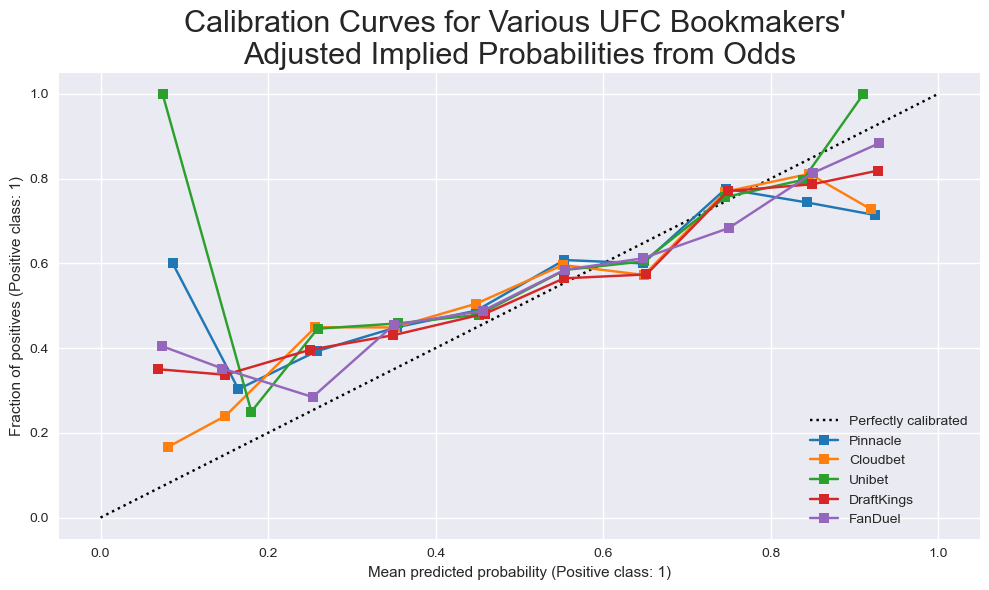

In [57]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss

plt.style.use("seaborn-v0_8")
fig = plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab10")
ax_calibration_curve = fig.add_subplot()

for i, bookie in enumerate(bookmaker_subset):
    display = CalibrationDisplay.from_predictions(
        bouts2["R_Result"], 
        bouts2["Adjusted Probability_" + bookie],
        n_bins=10,
        name=bookie,
        ax=ax_calibration_curve,
        color=colors(i)
    )

# ax_calibration_curve.grid(color="white")
ax_calibration_curve.set_title("Calibration Curves for Various UFC Bookmakers' \nAdjusted Implied Probabilities from Odds", fontsize=22)

plt.tight_layout()
plt.show()

In [39]:
def calibration_loss(y_true, y_prob, reducer="sum", nbins=10, normalize=True,
                     sample_weight=None, pos_label=None):
    if pos_label is None:
        pos_label = y_true.max()
    y_true = np.array(y_true == pos_label, int)
    step_size = 1 / float(nbins)
    loss = 0.
    count = 0.
    for x in np.arange(0, 1, step_size):
        bin_center = x + step_size / 2
        in_range = (x <= y_prob) & (y_prob < x + step_size)
        if sample_weight is None:
            delta_count = in_range.sum()
            avg_pred_true = (in_range * y_true).sum() / float(delta_count)
        else:
            delta_count = (in_range * sample_weight).sum()
            avg_pred_true = ((in_range * y_true * sample_weight).sum()
                             / float(delta_count))
        count += delta_count
        if reducer == "max":
            loss = max(loss, abs(avg_pred_true - bin_center))
        elif reducer == "sum":
            delta_loss = abs(avg_pred_true - bin_center) * delta_count
            if not np.isnan(delta_loss):
                loss += delta_loss
        else:
            raise ValueError("reducer is neither 'sum' nor 'max'")
    if reducer == "sum" and normalize:
        loss /= count
    return loss

In [41]:
calibration_loss(bouts2["R_Result"], bouts2["Adjusted Probability_Pinnacle"])

0.0691131498470948

In [55]:
log_losses = [log_loss(bouts2["R_Result"], bouts2["Adjusted Probability_" + bookie]) for bookie in bookmaker_subset]
brier_score_losses = [brier_score_loss(bouts2["R_Result"], bouts2["Adjusted Probability_" + bookie]) for bookie in bookmaker_subset]
eces = [calibration_loss(bouts2["R_Result"], bouts2["Adjusted Probability_" + bookie]) for bookie in bookmaker_subset]
mean_vigs = [round(bouts2["Vig_" + bookie].mean() * 100, 2) for bookie in bookmaker_subset]

df_metrics = pd.DataFrame.from_dict(
    {"Bookmaker": bookmaker_subset,
     "Log Loss": log_losses,
     "Brier Score Loss": brier_score_losses,
     "Expected Calibration Error": eces,
     "Mean Vig (House Edge) (%)": mean_vigs},
)
df_metrics

,Bookmaker,Log Loss,Brier Score Loss,Expected Calibration Error,Mean Vig (House Edge) (%)
0,Pinnacle,0.667268,0.235607,0.069449,4.71
1,Cloudbet,0.658231,0.231745,0.071669,5.23
2,Unibet,0.666562,0.236587,0.055590,5.37
3,DraftKings,0.663200,0.228608,0.081700,5.75
4,FanDuel,0.647257,0.223520,0.071133,5.25
